### Obtain basic molecular properties for enumerated acid-amine coupled products

In [1]:
import pandas as pd
from collections import defaultdict

import numpy as np
import os

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdMolDescriptors, Descriptors

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["font.family"] = "Arial"

import seaborn as sns
from tqdm.notebook import tqdm
import molprops_utils


In [2]:
if not os.path.exists("./figures"):
    os.makedirs("./figures")

In [3]:
def interpolate_data_df(df):
    """takes a dataframe of values and does interpolation"""
    
    prop_dict = {}
    minmax_dict = {}
    
    for p in list(df):
        minv = np.min(df[p])
        maxv = np.max(df[p])
        minmax_dict[p] = (minv,maxv)
        prop_dict[p] = np.interp(df[p],(minv,maxv),(0,1))
        
    df_out = pd.DataFrame(data=prop_dict)    
    return df_out, minmax_dict


# a new helper function
def interp_point(data_point,minmax_dict):
    dict_out = {}
    for i,k in enumerate(minmax_dict.keys()):
        minv,maxv = minmax_dict[k]
        dict_out[k] = np.interp(data_point[i],(minv,maxv),(0,1))
        
    return dict_out


### load data

In [4]:
data = pd.read_csv("./data_files/smiles_min_dist_dbank.csv",index_col=0)

### compute properties

In [7]:
result = []

for s in tqdm(data.smiles):
    result.append(molprops_utils.getallprops(s))


data["allprops"] = result
data[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]] = data.allprops.tolist()

data.drop("allprops",axis=1,inplace=True)
all_molprops = []

  0%|          | 0/57230 [00:00<?, ?it/s]

In [ ]:
## save and re-read, for safety

data.to_csv("./data_files/smiles_min_dist_dbank_props.csv",index=False)

data = pd.read_csv("./data_files/smiles_min_dist_dbank_props.csv")

### Examine distributions of ring count and bond edit distance

In [ ]:
# h = plt.hist2d(data.min_dist_all,data.SSSR,bins=[range(14),range(15)],norm="log",cmap="viridis")
h = plt.hist2d(data.min_dist_all,data.SSSR,bins=[range(13),range(10)],norm="log",cmap="viridis")
ax = plt.gca()
ax.set_xlabel("bond edit distance",fontsize=12)
ax.set_ylabel("number of rings",fontsize=12)
ax.set_xticks(np.arange(0.5,12,1))
ax.set_xticklabels(range(12))
ax.set_yticks(np.arange(0.5,9,1))
ax.set_yticklabels(range(9))
plt.colorbar(h[3])
plt.savefig("./figures/rings_dist_hist.png")
pass

### cut off at 6 bond edits

In [ ]:
small_rings = data[data.SSSR <= 4]
data_trunc = small_rings[small_rings.min_dist_all <= 6].copy()
data_trunc.reset_index(drop=True,inplace=True)

In [ ]:
len(data_trunc)

In [ ]:
amide_props = np.array(molprops_utils.getallprops("CCC(NCC)=O"))
# get the x axis text.
for ip, prop in enumerate(["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]):
    print(prop,np.min(data_trunc[prop]),amide_props[ip],np.max(data_trunc[prop]))
    
# Rounded versions of this cell's output, for plotting purposes.

x_locs_text = {'LogP': [-1.99, 0.53, 1.81],
 'MW': [51, 101, 119],
 'HBD': [0, 1, 3],
 'HBA': [0, 1, 3],
 'PSA': [0, 29, 66],
 'ROTB': [0, 2, 5],
 'FSP3': [0.0, 0.8, 1.0],
 'SSSR': [0, 0, 4],
 'QED': [0.12, 0.54, 0.60],
 'Rings': [0, 0, 4]}


### interpolate for plotting
the interpolation is for better control of axes. Can also be done without interpolation.

In [ ]:
props_interp, minmax_dict =  interpolate_data_df(data_trunc[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]])

# interpolated difference for plotting location
amide_interp = interp_point(amide_props,minmax_dict)

In [ ]:
# this order is different, due to the sorting in Figure 3.

props_interp = props_interp[['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']].copy()
df_plot = props_interp.melt(var_name = "property")


In [ ]:
x_locs_vals = {}
for k in amide_interp.keys():
    i = minmax_dict[k]
    minmax_interp = np.interp(i,(min(i),max(i)),(0,1))
    x_locs_vals[k] = [minmax_interp[0],amide_interp[k],minmax_interp[1]]
    

In [ ]:
for ik, k in enumerate(minmax_dict.keys()):
    i = minmax_dict[k]
#     print(k,i[0],amide_props[ik],i[1])

### plot kernel density figures

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.2)
g = sns.FacetGrid(df_plot,col = "property",
                  aspect=1,height=1.16798*2.5,col_wrap=3,
                  sharex=False,sharey=False,palette="plasma")

g.map(sns.kdeplot, "value",clip_on=True,fill=True,bw_method=0.2);
g.set(yticks=[])

g.despine(top=False, right=False)
titles = ['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']
         

for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
    title = titles[i]
    
    
    M_loc = amide_interp[title]
    ax.set_ylabel("")
    ax.set_xticks([])
    
    # was removed for publishing purposes
    ax.set_xticks(x_locs_vals[title])
    ax.set_xticklabels(x_locs_text[title],rotation=0,fontsize=18)
    
    ax.set_xlim(-.5,1.5)
    greys = 0.65
    ax.axvline(x_locs_vals[title][1], color=(greys,greys,greys), linewidth=2)
    if title == "SSSR":
        ax.set_title("Rings", fontweight='bold',fontsize=15)
    else:
        ax.set_title(title, fontweight='bold',fontsize=15)

g.set_xlabels("")
plt.tight_layout()
plt.subplots_adjust(hspace=0.41)

# g.fig.suptitle(r"Molecular Properties",fontweight='bold',fontsize=16)
plt.savefig(f"./figures/fig3_KDEs_3.svg",format="svg")

### get PMI ratios

In [6]:
# can take a while depending on the computer
# 5 minutes on 32 cores 

result = []
for s in tqdm(data_trunc.smiles):
    result.append(molprops_utils.cal_pmi(s))

NameError: name 'data_trunc' is not defined

In [18]:
data_trunc["pmi_x"] = [i[0] for i in result]
data_trunc["pmi_y"] = [i[1] for i in result]

In [19]:
data_trunc[["smiles","pmi_x","pmi_y"]].to_csv("./data_files/smiles_pmi_trunc.csv")

In [20]:
data_pmi = pd.read_csv("./data_files/smiles_pmi_trunc.csv",index_col=0)

### calculate average coordinates for amides. 

In [21]:
amide_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in "CCC(NCC)=O.C=CC(NCC)=O.C=CC(NC=C)=O.CCC(NC=C)=O".split(".")]

amide_data = data_pmi[data_pmi.smiles.isin(amide_smiles)]
amide_data

,smiles,pmi_x,pmi_y
7464,CCNC(=O)CC,0.194872,0.891577
7700,C=CC(=O)NCC,0.193682,0.887938


In [22]:
data_pmi.dropna(subset = ['pmi_x'],inplace=True)
data_pmi.reset_index(drop=True,inplace=True)

In [23]:
pmi_dict = {}

for s in amide_smiles:
    
    s_pmi = []
    for _ in range(100):
        s_pmi.append(molprops_utils.cal_pmi(s))
    pmi_dict[s] = s_pmi
    

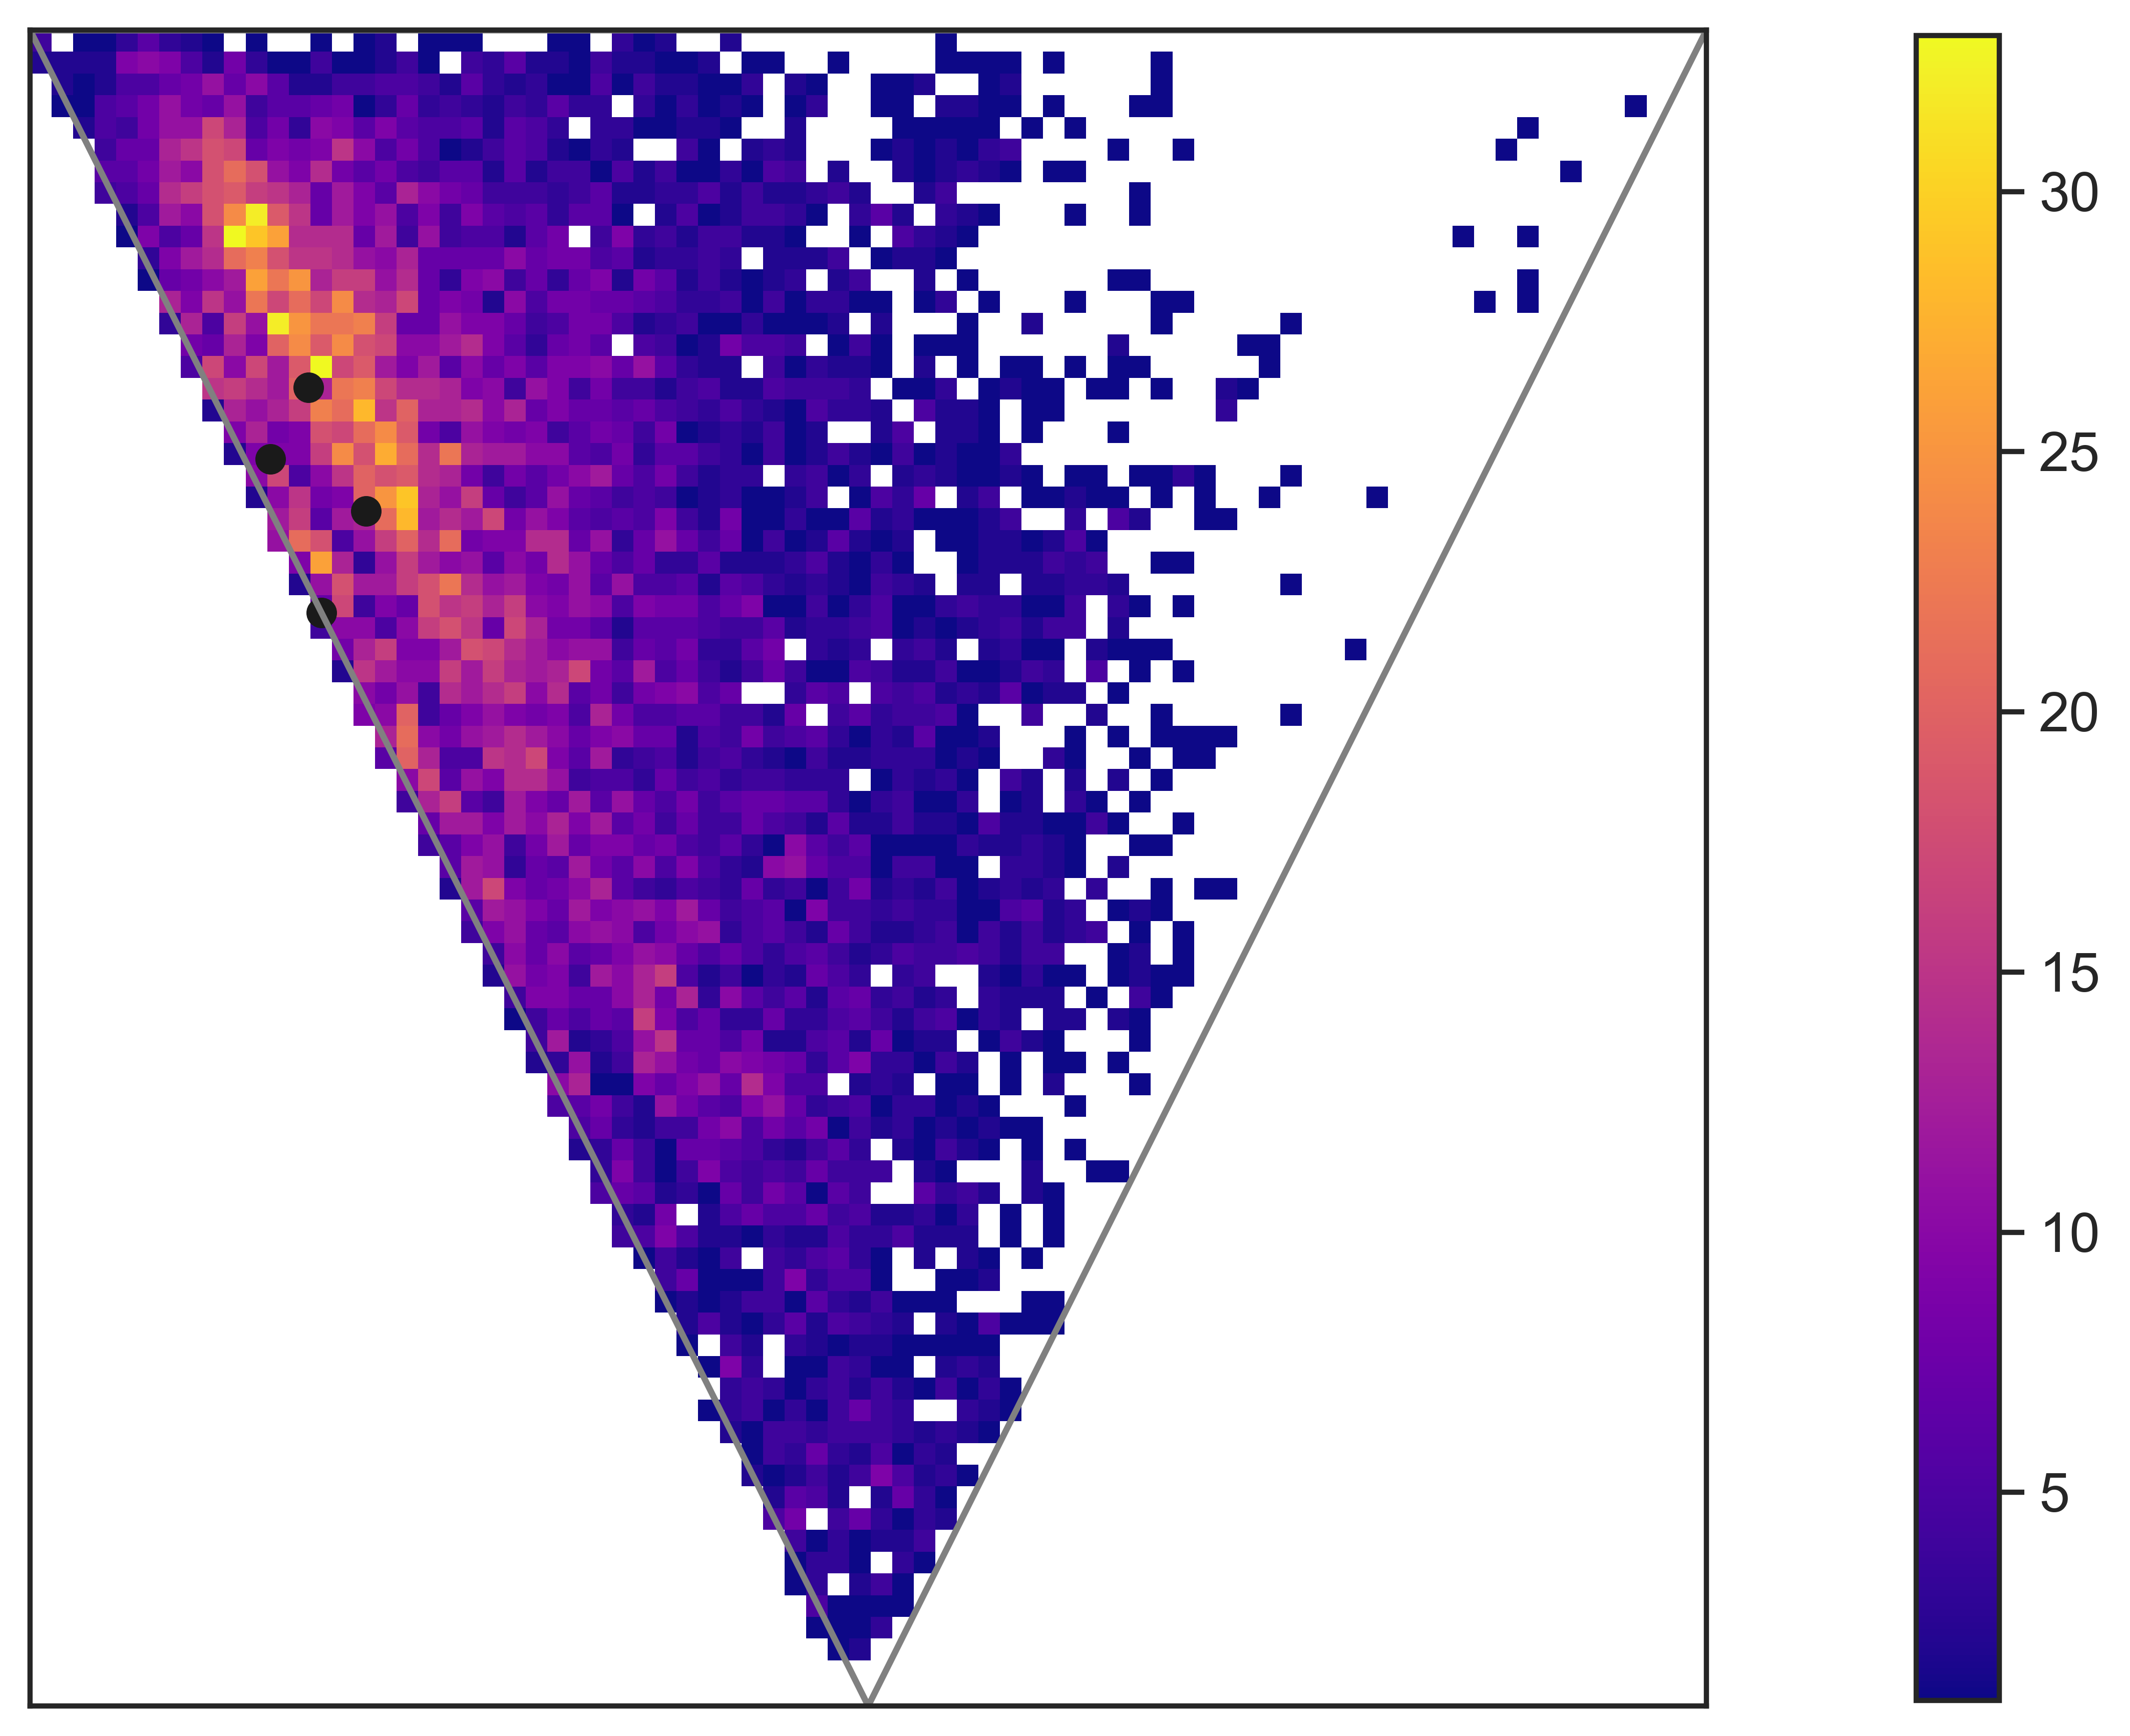

In [24]:
# make PMI ratio plot
fig, ax = plt.subplots(figsize=(18,18),dpi=600)

h = ax.hist2d(list(data_pmi.pmi_x), list(data_pmi.pmi_y),bins=75,cmin=1,cmap="plasma")


ax.set_xlim((0,1))
ax.set_ylim((0.5,1))
ax.plot([0,.5], [1,0.5],color='gray')
ax.plot([.5,1], [0.5,1],color='gray')
ax.plot([0,1], [1,1],color='gray')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
divider = make_axes_locatable(ax)
plt.colorbar(h[3],shrink=0.4)

# plot average position for the 4 amides 
for s in pmi_dict:
    pmi_data = np.array(pmi_dict[s])
    
    ax.scatter(np.mean(pmi_data[:,0]),np.mean(pmi_data[:,1]),alpha=1,s=40,color="k")

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('./figures/pmi_trunc.png')
pass

### elemental makeup for top 100 occurring substructures

In [25]:
data_plot = data_trunc.sort_values("drugbank_matches",ascending=False)[:100].copy()
data_plot["rank"] = range(1,len(data_plot)+1)

In [26]:
all_elems = []
for r in data_plot.itertuples():
    s = r.smiles
    elems = "C"
    if "N" in s or "n" in s:
        elems += "N"
        
    if "O" in s or "o" in s:
        elems += "O"
    all_elems.append(elems)

data_plot["elems"] = all_elems


C ['CCCC', 'CC(C)C', 'CC=CC', 'C=CCC', 'C=C(C)C']
CN ['CCNC', 'CCCN', 'CCCNC', 'CCNCC', 'CCCCN']
CO ['CCCO', 'CCC=O', 'CCCCO', 'CCOC', 'CC(C)O']
CNO ['CC(N)=O', 'CNC=O', 'NCCO', 'CNC(C)=O', 'CCNC=O']


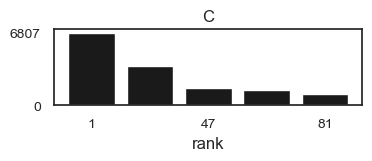

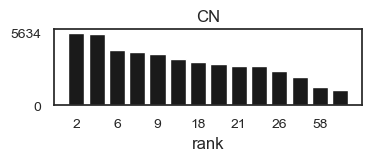

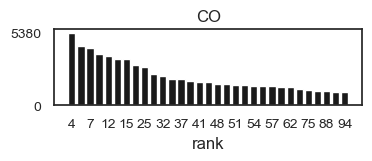

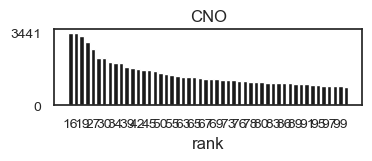

In [27]:
# plot bar charts of top occurring substructures

for elem in ["C","CN","CO","CNO"]:
    mm = 1/25.4
    data_plot_2 = data_plot[data_plot.elems==elem]
    
    
    print(elem, list(data_plot_2["smiles"])[:5])
    plt.figure(figsize=(101*mm,25*mm))
    plt.bar(range(len(data_plot_2)),data_plot_2.drugbank_matches,color="k")
    ax = plt.gca()
    ax.set_yticks([0,max(data_plot_2["drugbank_matches"])])
    ax.set_xticks(range(0,len(data_plot_2),2))
    
    ax.set_yticklabels([0,max(data_plot_2["drugbank_matches"])],font="Arial",size=10)
    ax.set_xticklabels(list(data_plot_2["rank"])[::2],rotation=0,font="Arial",size=10)
    
    
    plt.xlabel("rank",fontsize=12)
#     plt.ylabel("Frequency",fontsize=12)
    plt.title(elem,fontsize=12)
    
#     save if desired
#     plt.savefig(f"./figures/bar_{elem}.svg",format="svg")
